In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import sys
sys.path.append('../models')
import ResNet as resnet
import DenseNet as densenet
import EfficientNet as efficientnet
import MobileNetV2 as mobilenet
import ViT as vit

In [2]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    
    def forward(self, x):
        return x

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
##########################################
######### Configure Metric Setting ####### 
##########################################
batch_size = 64
weight_path = './weights/cifar10_resnet18_base.pt'
model = torch.load(weight_path)
criterion = nn.CrossEntropyLoss()
member_path = '/media/data1/hyunjun/cifar-10/train/'
nonmember_path = '/media/data1/hyunjun/cifar-10/test/'
data = 'Cifar-10'
##########################################
##########################################

In [5]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) 
if data == 'STL-10':
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
elif data == 'Cifar-10':
    mean, std = (0.491, 0.482, 0.447), (0.247, 0.243, 0.262)
elif data == 'CelebA':
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# model.fc = Identity()
model.to(device)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BasicBlock(
      (layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(6

In [6]:
nonmember_set = torchvision.datasets.ImageFolder(root=nonmember_path, transform=trans)
nonmember_loader = DataLoader(nonmember_set, batch_size=batch_size, shuffle=True, drop_last=False,)
member_set = torchvision.datasets.ImageFolder(root=member_path, transform=trans)
member_loader = DataLoader(member_set, batch_size=batch_size, shuffle=True, drop_last=False,)

classes = nonmember_set.classes

/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


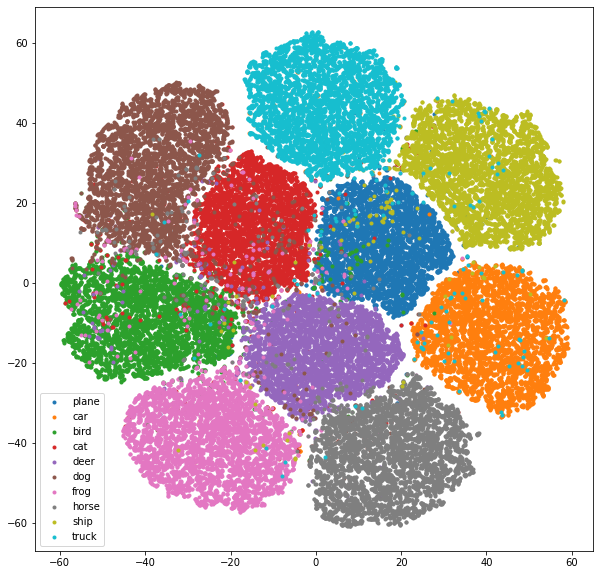

In [7]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in nonmember_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features, _ = model(images)

        deep_features += features.cpu().numpy().tolist()
        # actual += np.ones_like(labels.cpu().numpy()).tolist()
        actual += labels.cpu().numpy().tolist()
        
    for data in member_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features, _ = model(images)

        deep_features += features.cpu().numpy().tolist()
        # actual += np.zeros_like(labels.cpu().numpy()).tolist()
        actual += labels.cpu().numpy().tolist()
        
tsne = TSNE(n_components=2, random_state=0, perplexity=10.0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(10, 10))
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# labels = ['member', 'non_memeber']
for i, label in zip(range(10), labels):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()